In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input, Add
from keras.utils import to_categorical, plot_model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import cv2
import string
import glob
import pickle

In [2]:
def load_description(text):
    mapping = dict()
    for line in text.split("\n"):
        token = line.split("\t")
        if len(line) < 2:
            continue
        img_id = token[0].split('.')[0]
        img_des = token[1]
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_des)
    return mapping

token_path = "D:/mlproject/imgcaption_dataset/Flickr8k.token.txt"
text = open(token_path, 'r', encoding='utf-8').read()
descriptions = load_description(text)

In [3]:
def clean_description(desc):
    for key, des_list in desc.items():
        for i in range(len(des_list)):
            caption = des_list[i]
            caption = [ch for ch in caption if ch not in string.punctuation]
            caption = ''.join(caption)
            caption = caption.split(' ')
            caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
            caption = ' '.join(caption)
            des_list[i] = caption

clean_description(descriptions)

def to_vocab(desc):
    words = set()
    for key in desc.keys():
        for line in desc[key]:
            words.update(line.split())
    return words

vocab = to_vocab(descriptions)

In [4]:
images = "D:/mlproject/imgcaption_dataset/Flickr8kimages/Flicker8k_Dataset/"
img = glob.glob(images + '*.jpg')

train_path = "D:/mlproject/imgcaption_dataset/trainimagecaptions.txt"
train_images = open(train_path, 'r', encoding='utf-8').read().split("\n")
train_img = []

for im in img:
    if im[len(images):] in train_images:
        train_img.append(im)

In [5]:
def load_clean_descriptions(des, dataset):
    dataset_des = dict()
    for key, des_list in des.items():
        if key + '.jpg' in dataset:
            if key not in dataset_des:
                dataset_des[key] = list()
            for line in des_list:
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc)
    return dataset_des

train_descriptions = load_clean_descriptions(descriptions, train_images)
print(train_descriptions['1000268201_693b08cb0e'])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [6]:
def preprocess_img(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x


In [3]:
base_resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')
encoding_model = Model(inputs=base_resnet.input, outputs=base_resnet.output)


In [5]:
encoding_model.save('encoding_resnet_model.keras')

In [8]:
def encode(image_path):
    image = preprocess_img(image_path)
    vec = encoding_model.predict(image)
    vec = np.reshape(vec, (vec.shape[1]))
    return vec


In [9]:
image_path = r"D:/mlproject/imgcaption_dataset/Flickr8kimages/Flicker8k_Dataset/667626_18933d713e.jpg"
photo = encode(image_path)
print(photo.shape)


1/1 [==============================] - 3s 3s/step
(2048,)


In [10]:
all_train_captions = []
for key, val in train_descriptions.items():
    for caption in val:
        all_train_captions.append(caption)

vocabulary = vocab
threshold = 10
word_counts = {}
for cap in all_train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

vocab = [word for word in word_counts if word_counts[word] >= threshold]
ixtoword = {}
wordtoix = {}
ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1

max_length = max(len(des.split()) for des in all_train_captions)
print(max_length)

34


In [13]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key, desc_list in descriptions.items():
            n += 1
            photo = photos[key + '.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=len(wordtoix) + 1)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == num_photos_per_batch:
                yield [np.array(X1), np.array(X2)], np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0

In [14]:
embedding_dim = 200
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe3 = BatchNormalization()(fe2)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(len(wordtoix) + 1, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
se4 = BatchNormalization()(se3)

decoder1 = Add()([fe3, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
decoder3 = BatchNormalization()(decoder2)
outputs = Dense(len(wordtoix) + 1, activation='softmax')(decoder3)

caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')
caption_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 34, 200)              330400    ['input_5[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 2048)                 0         ['input_4[0][0]']             
                                                                                            

In [15]:
batch_size = 64
steps = len(train_descriptions) // batch_size

encoding_train = {}
for img in train_img:
    encoding_train[os.path.basename(img)] = encode(img)
np.save('encoded_train_images.npy', encoding_train)

encoding_train = np.load('encoded_train_images.npy', allow_pickle=True).item()

1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 158ms/step


1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 254ms/step


In [18]:
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_image_caption_model.h5', save_best_only=True, monitor='loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.001)



In [19]:
generator = data_generator(train_descriptions, encoding_train, wordtoix, max_length, batch_size)
hist = caption_model.fit(generator, epochs=20, steps_per_epoch=steps, verbose=1,
                         callbacks=[early_stopping, checkpoint, reduce_lr])

Epoch 1/20

93/93 [==============================] - ETA: 0s - loss: 5.4131

C:\Users\megak\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/93 [==============================] - 328s 3s/step - loss: 5.4131 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 297s 3s/step - loss: 3.8140 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 419s 5s/step - loss: 3.4720 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 423s 5s/step - loss: 3.2676 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 394s 4s/step - loss: 3.1247 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 291s 3s/step - loss: 3.0160 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 292s 3s/step - loss: 2.9264 - lr: 0.0010
Epoch 8/20
93/93 [==============================] - 292s 3s/step - loss: 2.8462 - lr: 0.0010
Epoch 9/20
93/93 [==============================] - 403s 4s/step - loss: 2.7792 - lr: 0.0010
Epoch 10/20
93/93 [==============================] - 421s 5s/step - loss: 2.7211 - lr: 0.0010
Epoch 11/20
93/93 [==============================] - 423s 5s/step - loss: 2.6664

In [20]:
caption_model.save('image_captionres_model.h5')

with open('res_wordtoix.pkl', 'wb') as f:
    pickle.dump(wordtoix, f)

with open('res_ixtoword.pkl', 'wb') as f:
    pickle.dump(ixtoword, f)

with open('res_max_length.pkl', 'wb') as f:
    pickle.dump(max_length, f)


In [21]:
caption_model = tf.keras.models.load_model('image_captionres_model.h5')

with open('res_wordtoix.pkl', 'rb') as f:
    wordtoix = pickle.load(f)

with open('res_ixtoword.pkl', 'rb') as f:
    ixtoword = pickle.load(f)

with open('res_max_length.pkl', 'rb') as f:
    max_length = pickle.load(f)


In [22]:
def generate_caption(model, photo, max_length, wordtoix, ixtoword):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [23]:
image_path =r"D:\mlproject\imgcaption_dataset\Flickr8kimages\Flicker8k_Dataset\36422830_55c844bc2d.jpg"
photo = encode(image_path)
photo = np.expand_dims(photo, axis=0)
caption = generate_caption(caption_model, photo, max_length, wordtoix, ixtoword)
print(caption)

1/1 [==============================] - 1s 893ms/step
man drives jeep through mud puddle


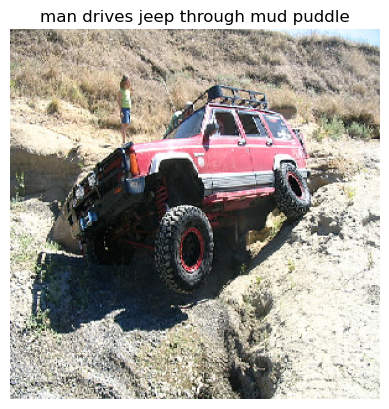

In [24]:
img = load_img(image_path, target_size=(299, 299))
plt.imshow(img)
plt.axis('off')
plt.title(caption)
plt.show()

In [1]:
import flask
import werkzeug
import os
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import matplotlib
import cv2
import pickle

print("Flask version:", flask.__version__)
print("Werkzeug version:", werkzeug.__version__)
print("OS module does not have a version")
print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("OpenCV version:", cv2.__version__)
print("Pickle is part of the Python Standard Library, no version info available")



Flask version: 2.2.2
Werkzeug version: 2.2.3
OS module does not have a version
NumPy version: 1.24.3
TensorFlow version: 2.15.0
Keras version: 2.15.0
Pandas version: 1.5.3
Matplotlib version: 3.7.1
OpenCV version: 4.9.0
Pickle is part of the Python Standard Library, no version info available
